# Comparing Support Vector Machines, Decision Trees and Naive Bayes for Heart Failure Prediction

Notebook for workshop assignment [Workshop: Compare Support Vector Machines to DTs and NB](https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971)

The notebook contains examples of how to use a wide range of machine learning techniques and functionality

In [127]:
# Notebook for Workshop: Compare Support Vector Machines, DTs and NB
# https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.base import BaseEstimator, ClassifierMixin 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, get_scorer
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from statsmodels.stats.contingency_tables import mcnemar

In [128]:
pd.set_option("display.max_columns", None)

I've added some markdown cells that provide some tips into how to discuss results. Note that my comments were made to a
particular run. Due the limitations with setup related to random sampling, we get different results each time we run. The discussions might therefore be slightly errornous when discussion concrete numbers, but they still provide valuable tips for how to discuss results.

In [129]:
# Load the dataset and show first 5 rows

dataset = pd.read_csv('../data/heart_failure/heart_failure_clinical_records_dataset.csv')
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Analysis and Processing

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'anaemia'}>,
        <Axes: title={'center': 'creatinine_phosphokinase'}>,
        <Axes: title={'center': 'diabetes'}>],
       [<Axes: title={'center': 'ejection_fraction'}>,
        <Axes: title={'center': 'high_blood_pressure'}>,
        <Axes: title={'center': 'platelets'}>,
        <Axes: title={'center': 'serum_creatinine'}>],
       [<Axes: title={'center': 'serum_sodium'}>,
        <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'time'}>],
       [<Axes: title={'center': 'DEATH_EVENT'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

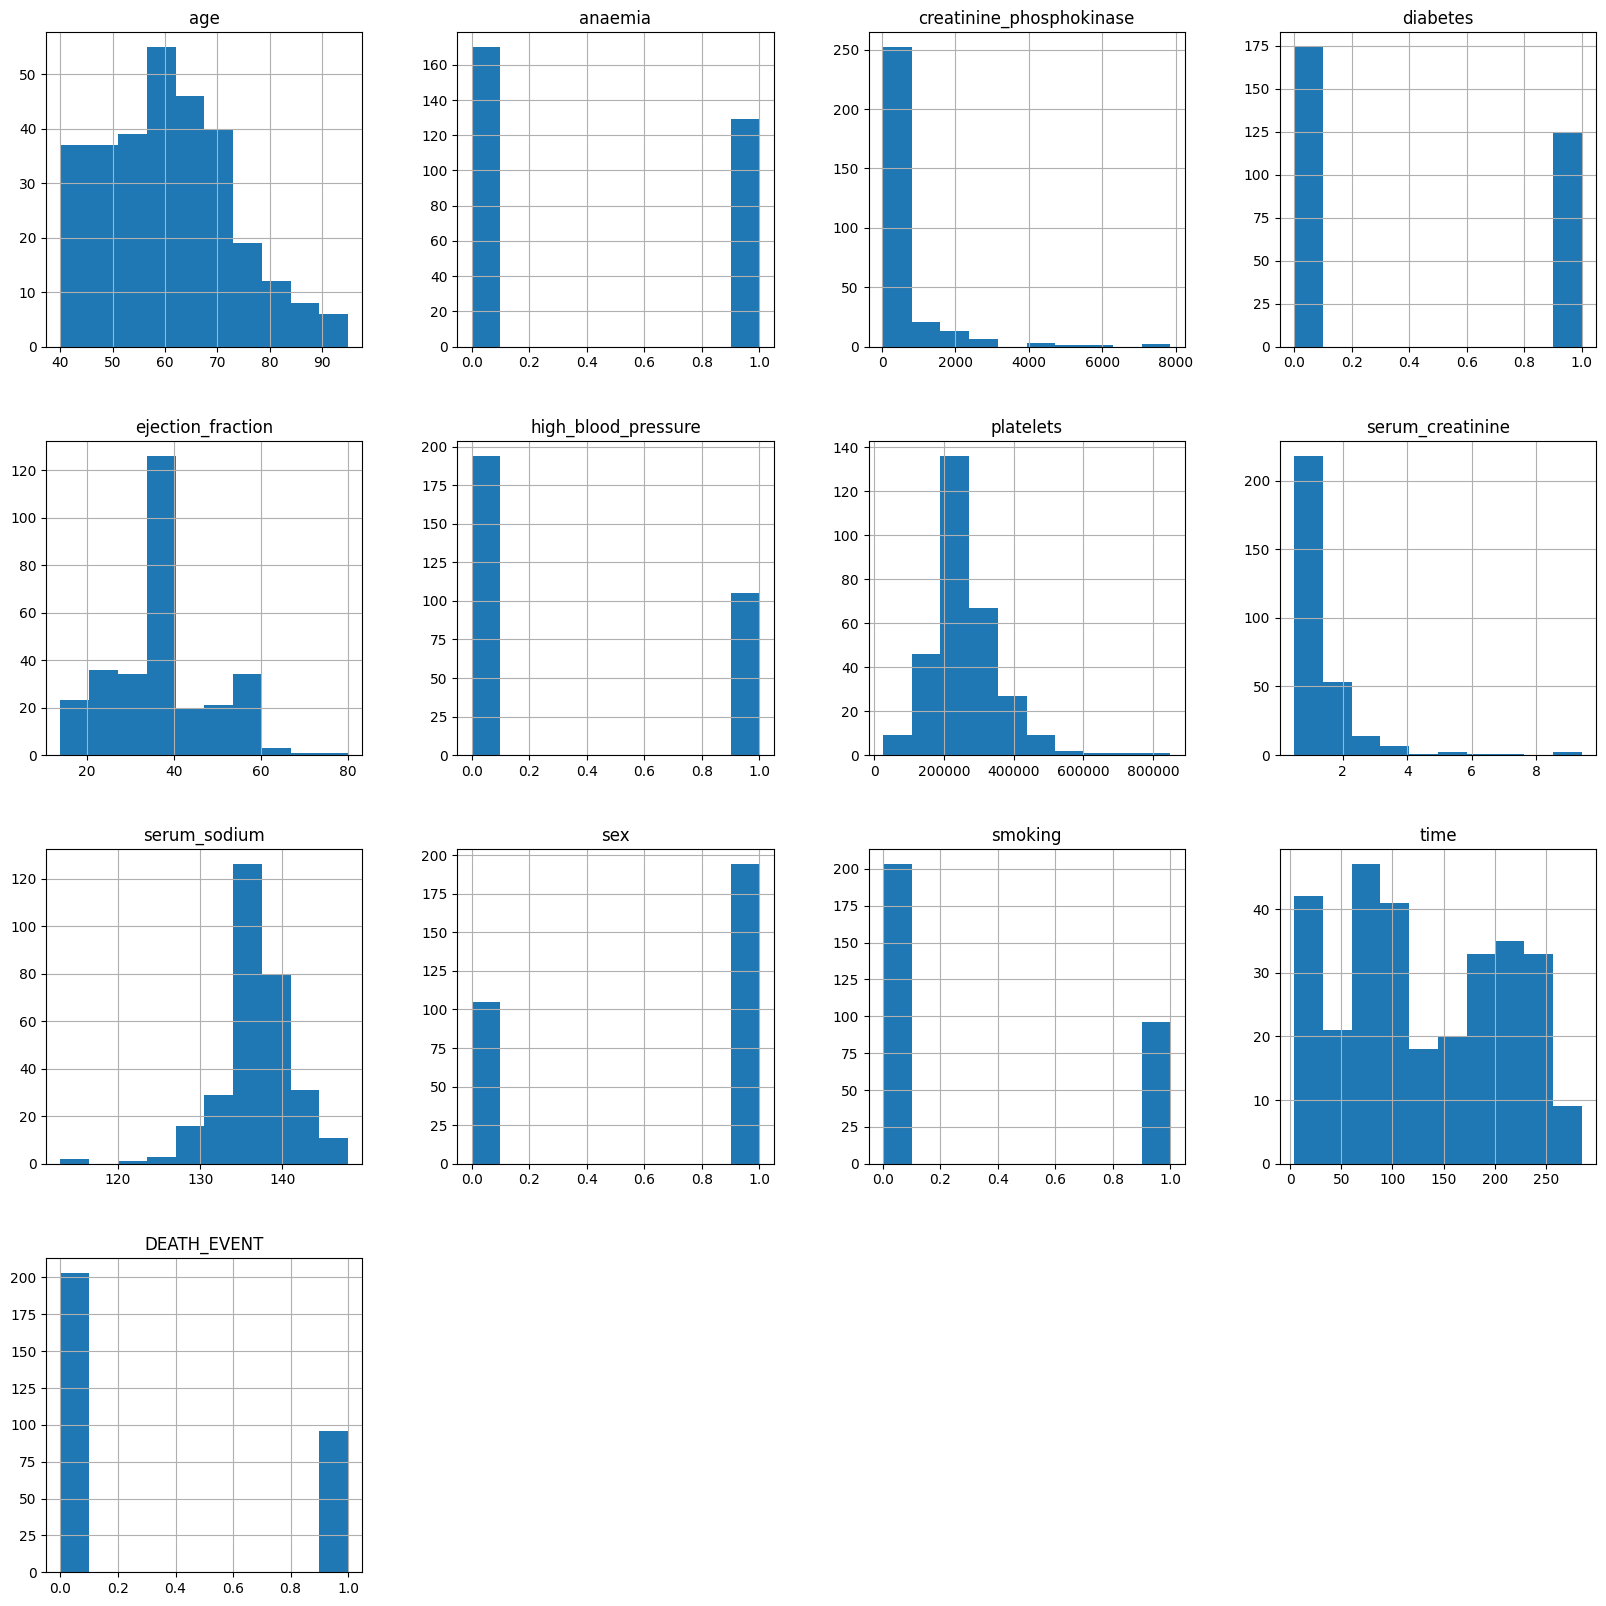

In [130]:
# Show the distribution of all the columns (both features and targets). We do this 
# to explore our data so that we better know how to proceed with the training. 
# This should be improved.

dataset.hist(figsize=(20,20))

We did this analysis to determine which version of naive bayes to use. We can see that some of the features are what we can consider normally distributed and some are binary. The normally distributed features aren't necessarily bell shaped like we would expect for normally distributed data, but they are closer to normally distributed than the alternative (binary/frequency).

The fact that we have two different types of distributions in our features means that we might have to create a custom classifier that combines a gaussian and bernoulli classifier to achieve optimal performance.

## Training & Tuning

In [131]:
# Split into 80/20. 80% for cross validated training, and 20% for final testing. Note that 
# these aren't used when were doing nested cross validation

trainval = dataset.groupby('DEATH_EVENT', group_keys=False)[dataset.columns].apply(lambda x: x.sample(frac=0.8))
test = dataset.drop(trainval.index)

In [132]:
# Separate input features from targets in all partitions

features = dataset.drop('DEATH_EVENT', axis=1)
targets = dataset['DEATH_EVENT']

trainval_features = trainval.drop('DEATH_EVENT', axis=1)
trainval_targets = trainval['DEATH_EVENT']

test_features = test.drop('DEATH_EVENT', axis=1)
test_targets = test['DEATH_EVENT']


In [133]:
# A custom function for evaluation the performance using accuracy, precision, recall, f1 and roc_auc.
# Works well for when your data partitions are fixed.
def evaluate(model):

    # Store the prediction probabilites and the predictions. We need the probabilities for 
    # roc_auc_score metric

    train_probabilities = model.predict_proba(trainval_features)
    # train_predictions = model.predict(train_features)
    # This does the same as the statement above without having the model predict again
    train_predictions = model.classes_.take(np.argmax(train_probabilities, axis=1), axis=0)

    # Print the training and validation scores

    print(f'Training Accuracy: {accuracy_score(trainval_targets, train_predictions)}')
    print(f'Training Precision: {precision_score(trainval_targets, train_predictions)}')
    print(f'Training Recall: {recall_score(trainval_targets, train_predictions)}')
    print(f'Training F1: {f1_score(trainval_targets, train_predictions)}')
    print(f'Training ROC AUC: {roc_auc_score(trainval_targets, train_probabilities[:,1])}')
    
    # Evaluate and print the final test scores     

    test_probabilities = model.predict_proba(test_features)
    test_predictions = model.classes_.take(np.argmax(test_probabilities, axis=1), axis=0)

    print(f'Test Accuracy: {accuracy_score(test_targets, test_predictions)}')
    print(f'Test Precision: {precision_score(test_targets, test_predictions)}')
    print(f'Test Recall: {recall_score(test_targets, test_predictions)}')
    print(f'Test F1: {f1_score(test_targets, test_predictions)}')
    print(f'Test ROC AUC: {roc_auc_score(test_targets, test_probabilities[:,1])}')
    print()

In [134]:
# A function for running tests on specified data
def evaluate2(estimator, X, y):
    # Get the prediction probabilities for each class
    probabilities = estimator.predict_proba(X)
    # Get the indices of the highest probabilities for each prediction
    prediction_indices = np.argmax(probabilities, axis=1)
    # Build a list with the appropriate class labels for each prediction
    predictions = estimator.classes_.take(prediction_indices, axis=0)

    return {
        'accuracy': accuracy_score(y, predictions), 
        'precision': precision_score(y, predictions), 
        'recall': recall_score(y, predictions), 
        'f1': f1_score(y, predictions), 
        'roc_auc': roc_auc_score(y, probabilities[:,1]), 
        }

In [135]:
# A custom function for returning the results for all metrics based on the best f1 score on test data
def show_cv_results(cv_results):
    # Sort the values in the frame according to their rank in f1
    sorted_results = cv_results.sort_values('rank_test_f1',ascending=True)
    # return the relevant scores for the first row of the data
    return sorted_results[['mean_train_f1', 'mean_train_precision', 'mean_train_recall', 'mean_train_accuracy', 'mean_train_roc_auc', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy', 'mean_test_roc_auc']].iloc[0]

In [136]:
# Define the metrics that we wan't to use. The names of available scorers can be accessed through
# get_scorer_names. The actual scorer objects are found using get_scorer. This is done internally in all sklearn 
# functions that accept metric names
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [137]:
# Train a decision tree using grid search and nested cross validation. A nested CV setup is 
# the best way of training, hyperparameter tuning, and a final evaluation on unseen test data.

dt_params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': range(1,21)
    # Needs to be expanded with more parameters
}

# Define our stratified kfold iterators, one for the outer iterations through the external test folds
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
# and one to be used by GridSearchCV in the inner iterations through the validation folds that is used to
# validate the performance hyperparameter values. The training data will consist of the remaining three 
# folds in each iteration. 
# Note that we pass in the same random seed to each iterator. We can now fix the random seed as we 
# are using the entire dataset for final testing irregardles of seed. 
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)

# Create lists for storing our results
dt_cv_results = []
dt_estimators = []
dt_test_scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': [],
}

# The iterators are used to split the data into training and test data
for (train_index, test_index) in list(outer_cv.split(features, targets)):

    # Employ grid search to find the hyperparameter values in the specified grid. We pass in the 
    # inner cv iterator
    dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=inner_cv, scoring=metrics, refit='f1',return_train_score=True)

    # Perform cross validated training and tuning on the current training and validation data
    dt_grid.fit(features.iloc[train_index], targets.iloc[train_index])

    # Store the cv results for current iteration
    cv_results = pd.DataFrame(dt_grid.cv_results_)
    dt_cv_results.append(cv_results)

    # Store the best estimator for the current iteration
    dt_estimators.append(dt_grid.best_estimator_)

    # Evaluate and store the scores of the best estimator on the current test fold
    evaluation = evaluate2(dt_grid, features.iloc[test_index], targets.iloc[test_index])
    dt_test_scores['accuracy'].append(evaluation['accuracy'])
    dt_test_scores['precision'].append(evaluation['precision'])
    dt_test_scores['recall'].append(evaluation['recall'])
    dt_test_scores['f1'].append(evaluation['f1'])
    dt_test_scores['roc_auc'].append(evaluation['roc_auc'])


In [138]:
dt_cv_results_frame = pd.concat(dt_cv_results, names=['test_split'], keys=range(5))

In [139]:
# Print the best estimators to verify that we have trained a different classifier for each 
# split (under the assumption that the best parameter values will be different between the iterations)
print(dt_estimators)

[DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=4), DecisionTreeClassifier(criterion='entropy', max_depth=3), DecisionTreeClassifier(criterion='entropy', max_depth=3), DecisionTreeClassifier(max_depth=12)]


<Axes: xlabel='param_criterion', ylabel='mean_test_f1'>

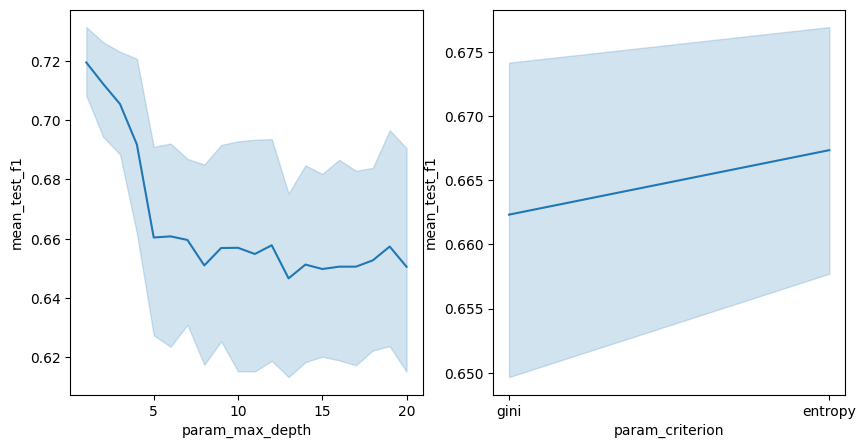

In [140]:
# Evaluate the performance of a parameter value accross all test splits (and other parameter values)
# We reset the index to be able to set a new index. This will make the test_split index become a 
# column
dt_cv_results_frame.reset_index(inplace=True)
# Fetch all relevant columns
param_scores = dt_cv_results_frame[['test_split', 'param_max_depth', 'param_criterion', 'mean_test_f1']]
# Set the desired index. In this case we set every thin except the score. This makes us able to access 
# values in groups according to what indices we specify
param_scores = param_scores.set_index(['test_split', 'param_max_depth', 'param_criterion'])

# Plot the scores
fig, axs = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=param_scores, x='param_max_depth', y='mean_test_f1', ax=axs[0])
sb.lineplot(data=param_scores, x='param_criterion', y='mean_test_f1', ax=axs[1])


In [141]:
# Calculate the confusion matrices for the best decision tree models, one for each test split 

dt_confusion_matrices = [confusion_matrix(targets.iloc[test_index], dt.predict(features.iloc[test_index])) for dt, (_, test_index) in zip(dt_estimators, outer_cv.split(features, targets))]
dt_confusion_matrices

[array([[36,  4],
        [ 7, 13]]),
 array([[31, 10],
        [ 5, 14]]),
 array([[40,  1],
        [ 8, 11]]),
 array([[37,  4],
        [ 7, 12]]),
 array([[31,  9],
        [10,  9]])]

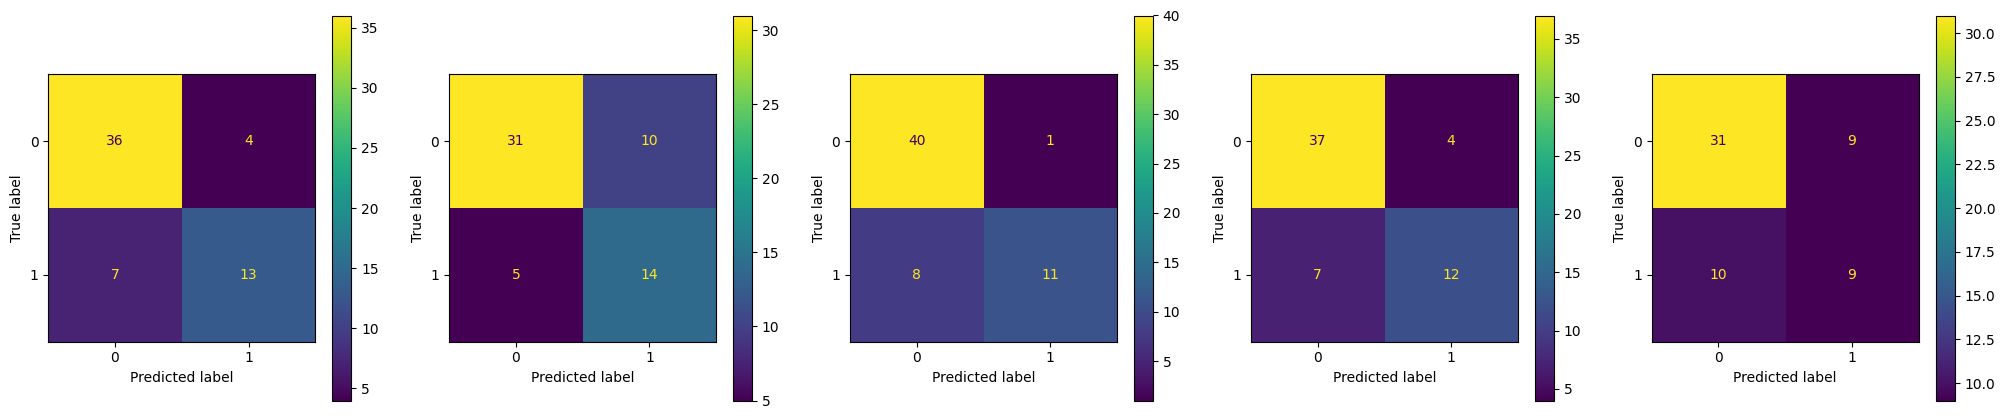

In [142]:
# Plot the matrices
fig, axs = plt.subplots(1,5, figsize=(25,5))
for i, (estimator, (_, test_index)) in enumerate(zip(dt_estimators, outer_cv.split(features, targets))):
    ConfusionMatrixDisplay.from_estimator(estimator, features.iloc[test_index], targets.iloc[test_index], ax=axs[i])

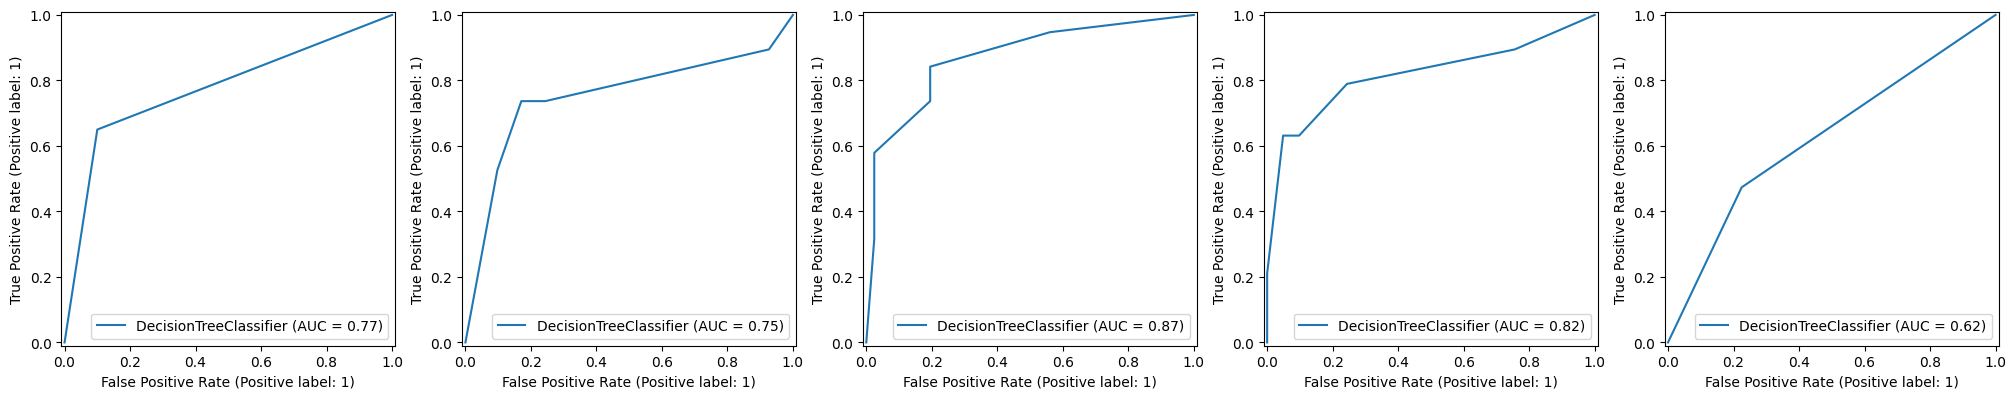

In [143]:
# Plot the ROC curve for the best decision tree model

fig, axs = plt.subplots(1,5, figsize=(25,5))
for i, (estimator, (_, test_index)) in enumerate(zip(dt_estimators, outer_cv.split(features, targets))):
    # These two statements achieves the same thing
    # RocCurveDisplay.from_predictions(test_targets, dt2.predict_proba(test_features)[:,1])
    RocCurveDisplay.from_estimator(estimator, features.iloc[test_index], targets.iloc[test_index], ax=axs[i])

In [144]:
# This shows how show_cv_results could work for nested cross validation

# Concat the cv_result frames together
cv_results_frame = pd.concat(dt_cv_results, names=['test_split'], keys=range(5), axis=0)
# Find the best scores for each split according to the maximum f1 scores
cv_scores = cv_results_frame.groupby('test_split').apply(lambda frame: frame.sort_values('rank_test_f1')[['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']].iloc[0])
# Show the cross validation results (no training results selected)
cv_scores


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
test_split,,,,,
0,0.853531,0.855611,0.657895,0.740659,0.801280
1,0.832274,0.763675,0.740132,0.744401,0.804488
2,0.819703,0.731746,0.752632,0.732362,0.818270
3,0.828107,0.735819,0.753289,0.740715,0.862612
4,0.850000,0.754284,0.804605,0.775971,0.837821


In [145]:
# Convert the test scores into a dataframe
dt_test_scores = pd.DataFrame(dt_test_scores)
dt_test_scores

,accuracy,precision,recall,f1,roc_auc
0,0.816667,0.764706,0.650000,0.702703,0.775000
1,0.750000,0.583333,0.736842,0.651163,0.752246
2,0.850000,0.916667,0.578947,0.709677,0.870988
3,0.816667,0.750000,0.631579,0.685714,0.817715
4,0.677966,0.500000,0.473684,0.486486,0.624342


In [146]:
# Show the mean scores across all test folds
dt_test_scores.mean()

accuracy     0.782260
precision    0.702941
recall       0.614211
f1           0.647149
roc_auc      0.768058
dtype: float64

In [147]:
# Train and evaluate a gaussian naive bayesian classifier using GridSearchCV

nb_params = {
    'var_smoothing': np.logspace(-10, -5, 6) # The values are specified with the exponents i.e. 1e-10, ..., 1e-5
}
nb_grid = GridSearchCV(GaussianNB(), nb_params, scoring=metrics, refit='f1', return_train_score=True)
nb_grid.fit(trainval_features, trainval_targets)

# Convert the cross validation results into a dataframe for easier analysis
nb_cv_results = pd.DataFrame(nb_grid.cv_results_)
nb_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.001718,0.000209,0.007956,0.000393,0.0,{'var_smoothing': 1e-10},0.833333,0.729167,0.770833,0.770833,0.765957,0.774025,0.033512,2,0.769634,0.795812,0.795812,0.816754,0.812500,0.798102,0.016590,1.000000,0.625000,0.857143,0.727273,0.642857,0.770455,0.141074,2,0.725000,0.810811,0.843750,0.809524,0.842105,0.806238,0.043185,0.466667,0.333333,0.3750,0.5000,0.600000,0.4550,0.094222,3,0.467742,0.483871,0.442623,0.557377,0.516129,0.493548,0.039842,0.636364,0.434783,0.521739,0.592593,0.620690,0.561234,0.074448,2,0.568627,0.606061,0.580645,0.660194,0.640000,0.611105,0.034648,0.921212,0.830303,0.873047,0.789062,0.862500,0.855225,0.044099,1,0.877594,0.891848,0.870240,0.903783,0.893548,0.887403,0.011972
1,0.001675,0.000012,0.007543,0.000094,0.0,{'var_smoothing': 1e-09},0.854167,0.729167,0.770833,0.791667,0.765957,0.782358,0.041169,1,0.801047,0.806283,0.790576,0.842932,0.822917,0.812751,0.018356,1.000000,0.625000,0.857143,0.750000,0.666667,0.779762,0.135735,1,0.800000,0.878788,0.838710,0.829787,0.818182,0.833093,0.026260,0.533333,0.333333,0.3750,0.5625,0.533333,0.4675,0.094074,1,0.516129,0.467742,0.426230,0.639344,0.580645,0.526018,0.076523,0.695652,0.434783,0.521739,0.642857,0.592593,0.577525,0.091583,1,0.627451,0.610526,0.565217,0.722222,0.679245,0.640932,0.054617,0.921212,0.824242,0.853516,0.787109,0.841667,0.845549,0.043983,2,0.866217,0.884471,0.861034,0.895082,0.883375,0.878036,0.012564
2,0.001591,0.000036,0.007269,0.000109,0.0,{'var_smoothing': 1e-08},0.854167,0.666667,0.708333,0.791667,0.787234,0.761613,0.066301,4,0.785340,0.795812,0.774869,0.848168,0.833333,0.807504,0.028333,0.900000,0.428571,0.625000,0.714286,0.692308,0.672033,0.152086,4,0.800000,0.870968,0.846154,0.847826,0.812500,0.835490,0.025740,0.600000,0.200000,0.3125,0.6250,0.600000,0.4675,0.176352,1,0.451613,0.435484,0.360656,0.639344,0.629032,0.503226,0.111297,0.720000,0.272727,0.416667,0.666667,0.642857,0.543784,0.170645,3,0.577320,0.580645,0.505747,0.728972,0.709091,0.620355,0.085130,0.896970,0.804040,0.820312,0.789062,0.847917,0.831660,0.038042,3,0.851338,0.863091,0.843632,0.878436,0.861414,0.859582,0.011777
3,0.001570,0.000014,0.007201,0.000099,0.0,{'var_smoothing': 1e-07},0.833333,0.687500,0.666667,0.812500,0.829787,0.765957,0.073204,3,0.780105,0.738220,0.738220,0.832461,0.822917,0.782384,0.040142,0.888889,0.500000,0.500000,0.769231,0.818182,0.695260,0.163906,3,0.812500,0.750000,0.789474,0.853659,0.818182,0.804763,0.034245,0.533333,0.266667,0.1875,0.6250,0.600000,0.4425,0.180170,4

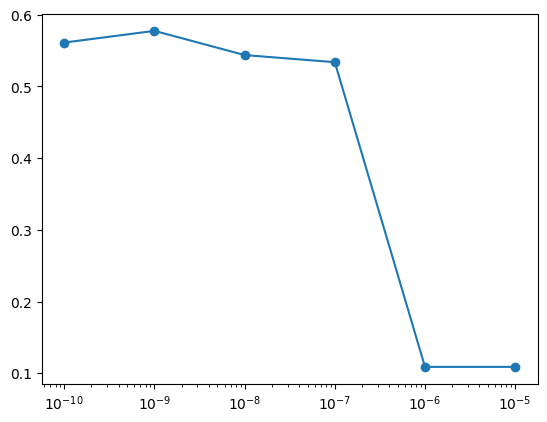

In [148]:
# Plot the performance of the different values for var_smoothing on cross validation data
fig, ax = plt.subplots(1,1)
# Set the scale of the x axis to be logarithmic
ax.set_xscale('log')
ax.scatter(nb_cv_results['param_var_smoothing'], nb_cv_results['mean_test_f1'])
ax.plot(nb_cv_results['param_var_smoothing'], nb_cv_results['mean_test_f1'])

In [149]:
# Show the results on training and (cross)validation data
show_cv_results(nb_cv_results)

mean_train_f1           0.640932
mean_train_precision    0.833093
mean_train_recall       0.526018
mean_train_accuracy     0.812751
mean_train_roc_auc      0.878036
mean_test_f1            0.577525
mean_test_precision     0.779762
mean_test_recall        0.467500
mean_test_accuracy      0.782358
mean_test_roc_auc       0.845549
Name: 1, dtype: float64

In [150]:
# Show the nb results on trainval and test data
evaluate(nb_grid.best_estimator_)

Training Accuracy: 0.8117154811715481
Training Precision: 0.8478260869565217
Training Recall: 0.5064935064935064
Training F1: 0.6341463414634146
Training ROC AUC: 0.8761423761423762
Test Accuracy: 0.75
Test Precision: 0.75
Test Recall: 0.3157894736842105
Test F1: 0.4444444444444444
Test ROC AUC: 0.8369704749679077



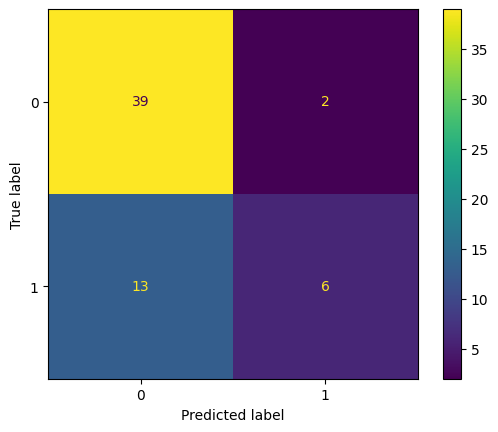

In [151]:
# Plot the confusion matrix for the best NB

ConfusionMatrixDisplay.from_estimator(nb_grid, test_features, test_targets)

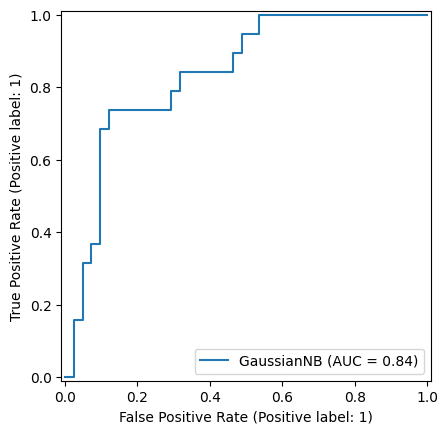

In [152]:
RocCurveDisplay.from_estimator(nb_grid.best_estimator_, test_features, test_targets)

In [153]:
# A custom "ensemble" classifier that makes it possible to have two different classifiers 
# for differents parts (features) of the data. 
# 
# It was meant to be a gaussian/bernoulli naive 
# bayes combination only, but, in order to make the classifier tunable through GridSearchCV, 
# we had to make the classifier open to accept any classifier for the different features.
#
# One must specify which features to use for each estimator by providing a list of column names.
#
# The order of the sub classes is important (as specified by scikit-learn docs)
class CombinedNB(ClassifierMixin, BaseEstimator):

    # The constructor specifiy the tunable parameters. The parameters of the nested classifiers 
    # will also be tunable by including them in the constructor header (e.g. param_gaussian__var_smoothing)
    def __init__(self, gaussian=GaussianNB(), gaussian_features=None, bernoulli=BernoulliNB(), bernoulli_features=None):
        
        self.gaussian_features = gaussian_features
        self.bernoulli_features  = bernoulli_features
        
        self.gaussian = gaussian 
        self.bernoulli = bernoulli 

    # Fit the combined classifier
    def fit(self, X, y):
        self.gaussian.fit(X[self.gaussian_features], y)
        self.bernoulli.fit(X[self.bernoulli_features], y)
        # Set the classes_ attribute to indicate that the estimator has been fitted. 
        # The classes_ attribute is used by GridSearchCV
        self.classes_ = self.gaussian.classes_
       
    # Predictions are made by invoking self.predict_proba and returning the index of
    # the class with the highest probability
    def predict(self, X):
        predict_proba = self.predict_proba(X)
        return np.argmax(predict_proba, axis=1)

    # Predict probabilites.
    def predict_proba(self, X):
        # Get the probabilities for each of the nested classifiers
        gaussian_proba = self.gaussian.predict_proba(X[self.gaussian_features])
        bernoulli_proba = self.bernoulli.predict_proba(X[self.bernoulli_features])
        # Combine the probabilities. 
        # Combine by addition/average. 
        # proba = (gaussian_proba + bernoulli_proba) / 2.0
        # Combine using multiplication. 
        proba = gaussian_proba * bernoulli_proba
        return proba


In [154]:
# Train a combined NB classifier using GridSearchCV
combined_params = {
    'gaussian__var_smoothing':np.logspace(-11, -5, 6),
    'bernoulli__alpha': np.logspace(-4, 0, 5)
}
gaussian_features = [
    'age', 
    'creatinine_phosphokinase', 
    'ejection_fraction', 
    'platelets',  
    'serum_creatinine', 
    'serum_sodium', 
    'time' ]
bernoulli_features = list(filter(lambda x: x not in gaussian_features, trainval_features.columns))
combined_grid = GridSearchCV(
    CombinedNB(gaussian_features=gaussian_features, bernoulli_features=bernoulli_features), 
    combined_params, 
    scoring=metrics,
    refit='f1', 
    return_train_score=True)
combined_grid.fit(trainval_features, trainval_targets)
combined_cv_results = pd.DataFrame(combined_grid.cv_results_)

In [155]:
# Show cross validation results for combined NB
show_cv_results(combined_cv_results)

mean_train_f1           0.546843
mean_train_precision    0.855754
mean_train_recall       0.402644
mean_train_accuracy     0.785553
mean_train_roc_auc      0.889779
mean_test_f1            0.519207
mean_test_precision     0.820130
mean_test_recall        0.390833
mean_test_accuracy      0.773936
mean_test_roc_auc       0.846584
Name: 1, dtype: float64

In [156]:
# Show cross validation results for NB
show_cv_results(nb_cv_results)

mean_train_f1           0.640932
mean_train_precision    0.833093
mean_train_recall       0.526018
mean_train_accuracy     0.812751
mean_train_roc_auc      0.878036
mean_test_f1            0.577525
mean_test_precision     0.779762
mean_test_recall        0.467500
mean_test_accuracy      0.782358
mean_test_roc_auc       0.845549
Name: 1, dtype: float64

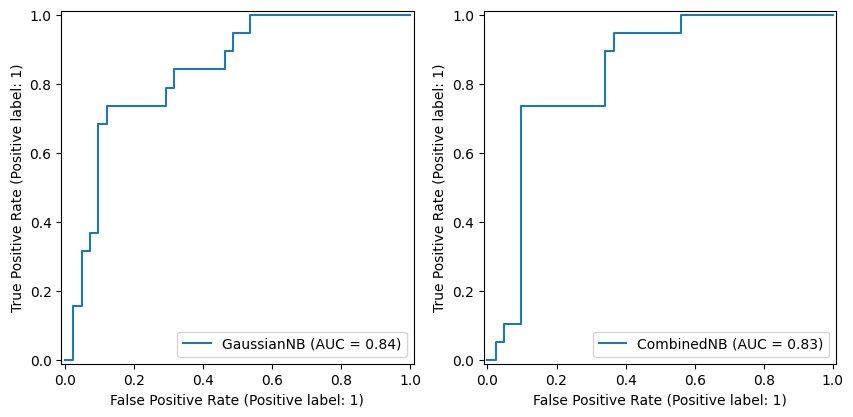

In [157]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
RocCurveDisplay.from_estimator(nb_grid.best_estimator_, test_features, test_targets, ax=axs[0])
RocCurveDisplay.from_estimator(combined_grid.best_estimator_, test_features, test_targets, ax=axs[1])

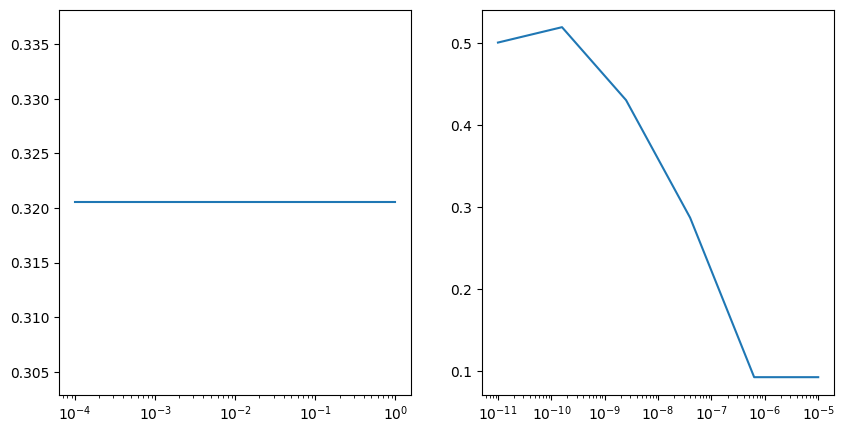

In [158]:
# Create a new frame with the relevant columns. We have tuned two parameters so far, and we want to find the best 
# values according to the f1 test (validation) results
combined_param_scores = combined_cv_results[['param_gaussian__var_smoothing', 'param_bernoulli__alpha', 'mean_test_f1']]

# Create a new frame where we have organized the values that we can find the average var_smoothing performance 
# accross the other parameter values
combined_var_smoothing = combined_param_scores.pivot_table(index='param_bernoulli__alpha', columns='param_gaussian__var_smoothing', values='mean_test_f1')
combined_var_smoothing_means = combined_var_smoothing.mean(axis=0)

# A frame to find the average performance of each bernoulli_alpha value
combined_alpha = combined_param_scores.pivot_table(index='param_gaussian__var_smoothing', columns='param_bernoulli__alpha', values='mean_test_f1')
combined_alpha_means = combined_alpha.mean(axis=0)

# Plot everything, one plot for each parameter tuned
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_xscale('log')
ax[0].plot(combined_alpha_means.index, combined_alpha_means)
ax[1].set_xscale('log')
ax[1].plot(combined_var_smoothing_means.index, combined_var_smoothing_means)
plt.show()

In [159]:
svc_params = {
    'C': [0.5, 1.0, 2.0, 4.0], 
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced', None]
}
svc_grid = GridSearchCV(SVC(probability=True), svc_params, scoring=metrics, refit='f1', return_train_score=True)
svc_grid.fit(trainval_features, trainval_targets)
svc_cv_results = pd.DataFrame(svc_grid.cv_results_)

/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lars/.venv/sklearn/lib/py

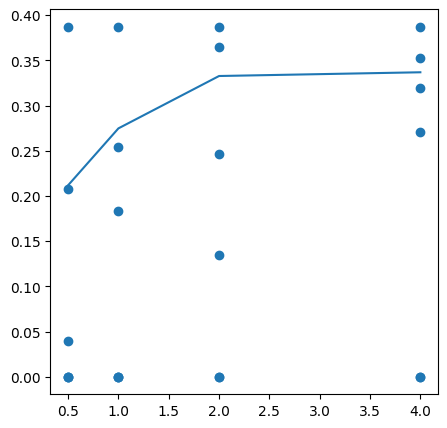

In [160]:
# Investigate the performance of the different parameter values

# Create a new frame with the relevant columns. We have tuned three parameters so far, and we want to find the best 
# values according to the f1 test (validation) results
svc_param_scores = svc_cv_results[['param_C', 'param_class_weight', 'param_kernel', 'mean_test_f1']]

# Create a new frame where we have organized the values that we can find the average C performance 
# accross the other parameter values
svc_c = svc_param_scores.pivot_table(index=['param_class_weight','param_kernel'], columns='param_C', values='mean_test_f1')
svc_c_means = svc_c.mean(axis=0)

# Plot everything, one plot for each parameter tuned
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(svc_c_means.index, svc_c_means)
ax.scatter(svc_cv_results['param_C'], svc_cv_results['mean_test_f1'])
plt.show()


In [161]:
show_cv_results(svc_cv_results)

mean_train_f1           0.403156
mean_train_precision    0.339259
mean_train_recall       0.803226
mean_train_accuracy     0.398249
mean_train_roc_auc      0.520598
mean_test_f1            0.387250
mean_test_precision     0.256826
mean_test_recall        0.787500
mean_test_accuracy      0.385993
mean_test_roc_auc       0.499260
Name: 1, dtype: float64

In [162]:
# Create a pipeline. Pipelines make it possible to build a tunable aggregated estimator. A list of estimators where every estimator except the last is expected 
# to support fit and transform, and the last to support predict.

# Create a scaling column transformer. This will scale age and time (uniform distributions) using minmax, and the remaining numerical features 
# with standard (mean) scaling. The remaining features (boolean) are passed through
scaling_transform = ColumnTransformer([
    ('minmax', MinMaxScaler(), ['age', 'time']),
    ('standard', StandardScaler(), ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium'])],
    remainder='passthrough')
# Create a pipeline that combines the scaling transformer with a SVC classifier
pipeline = Pipeline([('scaling', scaling_transform), ('svc', SVC(probability=True))])

In [163]:
# Create the gridsearch parameter grid. This could include parameters for the scaling transformer e.g. tune 
# whether or not to scale the features
pipeline_params = {
    'svc__C': [0.5, 1.0, 2.0, 4.0], 
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],
}
pipeline_grid = GridSearchCV(pipeline, pipeline_params, scoring=metrics, refit='f1', return_train_score=True)
pipeline_grid.fit(trainval_features, trainval_targets)
pipeline_cv_results = pd.DataFrame(pipeline_grid.cv_results_)

In [164]:
show_cv_results(pipeline_cv_results)

mean_train_f1           0.555331
mean_train_precision    0.598220
mean_train_recall       0.519408
mean_train_accuracy     0.732210
mean_train_roc_auc      0.717331
mean_test_f1            0.609080
mean_test_precision     0.663880
mean_test_recall        0.569167
mean_test_accuracy      0.765248
mean_test_roc_auc       0.785051
Name: 11, dtype: float64

In [165]:
# Here you should add a collected presentation of all the results to make it easy to make the final 
# conclusion. I've kept it simple here by only showing the evaluation metrics, but more evaluation 
# methods should be employed

# show the mean test score results for the dt model
dt_test_scores.mean()

accuracy     0.782260
precision    0.702941
recall       0.614211
f1           0.647149
roc_auc      0.768058
dtype: float64

In [166]:
evaluate(nb_grid.best_estimator_)
evaluate(combined_grid.best_estimator_)
evaluate(pipeline_grid.best_estimator_)

Training Accuracy: 0.8117154811715481
Training Precision: 0.8478260869565217
Training Recall: 0.5064935064935064
Training F1: 0.6341463414634146
Training ROC AUC: 0.8761423761423762
Test Accuracy: 0.75
Test Precision: 0.75
Test Recall: 0.3157894736842105
Test F1: 0.4444444444444444
Test ROC AUC: 0.8369704749679077

Training Accuracy: 0.7866108786610879
Training Precision: 0.8611111111111112
Training Recall: 0.4025974025974026
Training F1: 0.5486725663716814
Training ROC AUC: 0.8889690556357223
Test Accuracy: 0.6666666666666666
Test Precision: 0.4
Test Recall: 0.10526315789473684
Test F1: 0.16666666666666666
Test ROC AUC: 0.8318356867779204

Training Accuracy: 0.7154811715481172
Training Precision: 0.5714285714285714
Training Recall: 0.4675324675324675
Training F1: 0.5142857142857142
Training ROC AUC: 0.7268718935385602
Test Accuracy: 0.7666666666666667
Test Precision: 0.7272727272727273
Test Recall: 0.42105263157894735
Test F1: 0.5333333333333333
Test ROC AUC: 0.8369704749679076



In [167]:
# A function for finding the contingency table for two sets of predictions. 
# Returns a 2x2 array
# [[ NumBothCorrect, NumFirstCorrectSecondWrong ]
#  [ NumFirstWrongSecondRight, NumBothWrong ]]
def contingency(true, predictions1, predictions2):
    correct1 = true == predictions1
    correct2 = true == predictions2
    wrong1 = true != predictions1
    wrong2 = true != predictions2
    return np.array([
        [np.sum(correct1 & correct2), np.sum(correct1 & wrong2)], 
        [np.sum(correct2 & wrong1), np.sum(wrong1 & wrong2)]])

In [168]:
# The two best performers (disregarding nested crossvalidation results for DT since those results are not comparable to the rest) are nb and pipeline. A 
# statistical test can verify if one is better than the other i.e. if the two distributions differ 
# Null hypothesis - No difference
# Alternate - one is better than the other (p-value less than 0.05) 
contingency_nb_pipeline = contingency(test_targets.to_numpy(), nb_grid.best_estimator_.predict(test_features), pipeline_grid.best_estimator_.predict(test_features))
print(contingency_nb_pipeline)
print(mcnemar(contingency_nb_pipeline))

[[40  5]
 [ 6  9]]
pvalue      1.0
statistic   5.0


No difference